# Bayes Project
### Authors: Josh Gen, Matt Manner, Connor Nickol
#### 12/09/2022

#### Description: Using Bayesian Logistic Regression (calculated through Variational Inference) to identify defensive coverages in the NFL (data is the first 8 weeks of the 2021 NFL season)

In [5]:
import pandas as pd
import numpy as np
import pymc as pm
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 500)
import arviz as az
import matplotlib.pyplot as plt

# Read in data

In [6]:
# select all defensive players and save as a list to filter the locational data on
players = pd.read_csv("https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/players.csv")

defensive_positions = ['CB', 'DE', 'OLB', 'FS', 'DT', 'SS', 'ILB', 'NT', 'MLB', 'DB', 'LB']
defensive_players_df = players[players['officialPosition'].isin(defensive_positions)]
defensive_players_list = defensive_players_df['nflId']

In [7]:
# We only want one row for each play which is where the event is ball snap and only rows for defensive players
# The following code reads in each dataset for weeks 1-8 and only keeps rows where the event is ball snap AND 
#     where the nflid is a defensive player
locations = pd.DataFrame()
for i in range(1,8):
    url = 'https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/week'+str(i)+'.csv'
    week_data = pd.read_csv(url)
    week_data = week_data[week_data['event'] == 'ball_snap'] # only ball snap
    week_data = week_data[(week_data['nflId'].isin(defensive_players_list)) | (week_data['team'] == 'football')]
    locations = pd.concat([locations, week_data])


## Clean Data

In [8]:
# create unique play ID for each play
locations['uniqueplayId'] = locations['gameId'].astype(str) + locations['playId'].astype(str)

In [9]:
# Filter out the irrelevant and uncommon coverages

plays = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/plays.csv')
## Filter out some of the coverages
plays = plays[plays.pff_passCoverage != 'Bracket']
plays = plays[plays.pff_passCoverage != 'Goal Line']
plays = plays[plays.pff_passCoverage != 'Miscellaneous']
plays = plays[plays.pff_passCoverage != 'Prevent']
plays = plays[plays.pff_passCoverage != 'Red Zone']

plays['uniqueplayId'] = plays['gameId'].astype(str) + plays['playId'].astype(str)

# merge the locational dataset with the plays dataset to remove these coverages in locational dataset
locations_ball = plays.merge(locations, on='uniqueplayId')

In [10]:
locations_ball

,gameId_x,playId_x,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,DAL,right,43.30,18.89,0.96,0.90,0.11,316.48,288.76,ball_snap
1,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,DAL,right,43.90,32.63,0.37,2.44,0.06,278.77,247.75,ball_snap
2,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,DAL,right,44.68,29.35,0.39,0.24,0.07,266.46,167.48,ball_snap
3,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,DAL,right,43.61,37.62,0.17,0.14,0.01,295.95,58.77,ball_snap
4,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,DAL,right,44.61,36.36,2.54,1.46,0.26,79.23,179.45,ball_snap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84817,2021102500,3945,"(1:23) (No Huddle, Shotgun) G.Smith sacked at ...",4,3,18,SEA,NO,SEA,17,...,NO,left,92.73,28.23,0.37,1.46,0.04,86.89,107.90,ball_snap
84818,2021102500,3945,"(1:23) (No Huddle, Shotgun) G.Smith sacked at ...",4,3,18,SEA,NO,SEA,17,...,NO,left,92.12,19.68,0.05,0.83,0.02,348.90,81.67,ball_snap
84819,2021102500,3945,"(1:23) (No Huddle, Shotgun) G.Smith sacked at ...",4,3,18,SEA,NO,SEA,17,...,NO,left,92.21,37.91,0.01,0.01,0.00,109.38,174.25,ball_snap
84820,2021102500,3945,"(1:23) (No Huddle, Shotgun) G.Smith sacked at ...",4,3,18,SEA,NO,SEA,17,...,NO,left,91.23,46.21,0.15,0.48,0.00,85.43,239.03,ball_snap


In [11]:
# Add the location of the football on the play to each row then standardize x and y on this location
locations_ball = locations_ball.loc[locations_ball['team'] == 'football',
                               ['uniqueplayId', 'x', 'y']
                               ].rename(columns={'x':'football_x',
                                                 'y':'football_y'}).merge(locations_ball, on='uniqueplayId', how='right')
locations_ball['new_x'] = abs(locations_ball['x']-locations_ball['football_x'])
locations_ball['new_y'] = np.where(locations_ball['playDirection']=='right', 
                                   locations_ball['football_y']-locations_ball['y'],
                                   locations_ball['y']-locations_ball['football_y'])

In [12]:
locations_ball

,uniqueplayId,football_x,football_y,gameId_x,playId_x,playDescription,quarter,down,yardsToGo,possessionTeam,...,x,y,s,a,dis,o,dir,event,new_x,new_y
0,202109090097,41.56,23.92,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,...,43.30,18.89,0.96,0.90,0.11,316.48,288.76,ball_snap,1.74,5.03
1,202109090097,41.56,23.92,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,...,43.90,32.63,0.37,2.44,0.06,278.77,247.75,ball_snap,2.34,-8.71
2,202109090097,41.56,23.92,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,...,44.68,29.35,0.39,0.24,0.07,266.46,167.48,ball_snap,3.12,-5.43
3,202109090097,41.56,23.92,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,...,43.61,37.62,0.17,0.14,0.01,295.95,58.77,ball_snap,2.05,-13.70
4,202109090097,41.56,23.92,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,...,44.61,36.36,2.54,1.46,0.26,79.23,179.45,ball_snap,3.05,-12.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84817,20211025003945,94.49,26.51,2021102500,3945,"(1:23) (No Huddle, Shotgun) G.Smith sacked at ...",4,3,18,SEA,...,92.73,28.23,0.37,1.46,0.04,86.89,107.90,ball_snap,1.76,1.72
84818,20211025003945,94.49,26.51,2021102500,3945,"(1:23) (No Huddle, Shotgun) G.Smith sacked at ...",4,3,18,SEA,...,92.12,19.68,0.05,0.83,0.02,348.90,81.67,ball_snap,2.37,-6.83
84819,20211025003945,94.49,26.51,2021102500,3945,"(1:23) (No Huddle, Shotgun) G.Smith sacked at ...",4,3,18,SEA,...,92.21,37.91,0.01,0.01,0.00,109.38,174.25,ball_snap,2.28,11.40
84820,20211025003945,94.49,26.51,2021102500,3945,"(1:23) (No Huddle, Shotgun) G.Smith sacked at ...",4,3,18,SEA,...,91.23,46.21,0.15,0.48,0.00,85.43,239.03,ball_snap,3.26,19.70


In [13]:
# Remove rows with extreme football y values

locations_ball = locations_ball.loc[locations_ball['football_y']>0]
locations_ball = locations_ball.loc[locations_ball['football_y']<50]

In [14]:
# Remove rows with players x values > 25 (the min of x is already -25)

long_play_ids = locations_ball.loc[locations_ball['new_x']>25]['uniqueplayId'].tolist()

locations_ball = locations_ball[~locations_ball['uniqueplayId'].isin(long_play_ids)]

In [15]:
# bin both the x and y coordinates into discrete bins with predefined sizes

x_step = 2
def x_bin(x):
    return np.floor(x/x_step)*x_step

y_step = 1
def y_bin(y):
    return np.floor(y/y_step)*y_step

locations_ball["x_bin"] = x_bin(locations_ball['new_x'])
locations_ball["y_bin"] = y_bin(locations_ball['new_y'])

In [16]:
# Check the y bins

locations_ball['y_bin'].unique()

array([  5.,  -9.,  -6., -14., -13.,  -2.,  -4.,   1.,   8.,  -3.,   0.,
        -5.,   3.,   9.,  19.,   4., -16.,   2.,  -1.,  11.,   6., -10.,
        -7., -20.,  15.,   7., -19., -11.,  16.,  -8.,  10., -18.,  12.,
       -21.,  20.,  14.,  13., -15., -12., -17.,  18.,  21.,  17., -23.,
        22., -22.,  23.,  24., -24., -25.])

In [17]:
# Check the x bins

locations_ball['x_bin'].unique()

array([ 0.,  2., 16.,  6.,  4.,  8., 10., 12., 14., 20., 18., 22., 24.])

In [18]:
# Create grid categorizations by combining x and y bins as strings

locations_ball['bin'] = locations_ball['x_bin'].astype(int).astype(str) + "," + locations_ball['y_bin'].astype(int).astype(str)

In [19]:
# Check the most common bins for the defense to be in

locations_ball['bin'].value_counts()

0,0       8827
0,-6      3655
0,2       3490
0,5       3377
0,-3      3217
0,-1      1946
0,6       1816
0,-7      1640
0,-2      1611
0,1       1557
0,-5      1427
0,4       1403
0,3       1074
0,-4       871
4,-3       845
4,2        829
4,1        732
4,-2       728
4,0        677
4,-1       673
0,7        620
2,-3       609
4,3        598
2,2        550
4,-4       515
0,-8       469
2,-6       462
4,4        454
2,-2       446
2,1        444
2,6        430
2,5        418
4,5        414
2,0        385
2,-1       369
2,3        361
2,-4       357
4,-5       354
2,7        354
2,-7       350
4,-6       344
4,6        337
2,8        318
4,9        317
6,10       316
2,4        316
2,-8       308
4,-10      300
4,7        295
4,-7       294
2,-9       294
4,-9       292
0,8        287
0,-10      283
0,-9       280
2,-5       277
4,10       275
2,9        272
6,11       269
2,-10      267
4,8        265
6,-12      263
6,-11      262
4,-8       246
2,10       245
0,9        244
4,-11     

In [20]:
# Remove the football

locations_ball = locations_ball[locations_ball['team'] != 'football']

# Create and Format the Data for Modeling

In [21]:
# Create model data which removes all rows from locations except the unique play ID and the bin

model_data = locations_ball[['uniqueplayId', 'bin']]
model_data

,uniqueplayId,bin
0,202109090097,"0,5"
1,202109090097,"2,-9"
2,202109090097,"2,-6"
3,202109090097,"2,-14"
4,202109090097,"2,-13"
...,...,...
84816,20211025003945,"16,-9"
84817,20211025003945,"0,1"
84818,20211025003945,"2,-7"
84819,20211025003945,"2,11"


In [22]:
# Pivot the bin variable into dummies for each bin with the number of players in that bin on a specific play as the value

model_data = pd.get_dummies(model_data, columns=['bin'])
model_data = model_data.groupby(['uniqueplayId']).sum().reset_index()

In [23]:
# Combine the dummies with the response variable (pass coverage) and a unique play identifier

final_data = model_data.merge(plays[['uniqueplayId', 'pff_passCoverage']], on='uniqueplayId', how='left')

In [24]:
# Check how many values there are for a specific play (there should only be 11)

final_data.drop(['uniqueplayId', 'pff_passCoverage'], axis=1).sum(axis=1).value_counts()

11    7021
10      33
12       3
dtype: int64

The above result shows something interesting about this data. This data is every NFL snap in the 2021 season for the first 8 weeks. The result here shows that for 33 plays, the defensive team only had 10 players on the field, something that should be rare but could concievably happen. Even more interestingly is that there were 3 plays where 12 players were recorded on the field, indicating that the refs failed to identify 12 men on the field for these 3 plays.

In [25]:
# Check the max of each of the bins to see if there are ever 2 or even 3 players in a specific bin on a specific play

final_data.drop(['uniqueplayId', 'pff_passCoverage'], axis=1).max()

bin_0,-1      2
bin_0,-10     1
bin_0,-11     1
bin_0,-12     1
bin_0,-13     1
bin_0,-14     2
bin_0,-15     1
bin_0,-16     1
bin_0,-17     1
bin_0,-18     1
bin_0,-19     1
bin_0,-2      2
bin_0,-20     1
bin_0,-21     1
bin_0,-22     1
bin_0,-23     1
bin_0,-24     1
bin_0,-3      2
bin_0,-4      2
bin_0,-5      3
bin_0,-6      2
bin_0,-7      2
bin_0,-8      1
bin_0,-9      1
bin_0,0       2
bin_0,1       2
bin_0,10      1
bin_0,11      1
bin_0,12      1
bin_0,13      1
bin_0,14      1
bin_0,15      1
bin_0,16      1
bin_0,17      1
bin_0,18      1
bin_0,19      1
bin_0,2       2
bin_0,20      1
bin_0,21      1
bin_0,22      1
bin_0,23      1
bin_0,3       2
bin_0,4       2
bin_0,5       2
bin_0,6       2
bin_0,7       1
bin_0,8       1
bin_0,9       1
bin_10,-1     1
bin_10,-10    1
bin_10,-11    1
bin_10,-12    1
bin_10,-13    1
bin_10,-14    1
bin_10,-15    1
bin_10,-16    1
bin_10,-17    1
bin_10,-18    1
bin_10,-19    1
bin_10,-2     1
bin_10,-20    1
bin_10,-21    1
bin_10,-

In [26]:
# Here is the single play where three players are located in one box

final_data.loc[final_data['bin_0,-5']==3]

,uniqueplayId,"bin_0,-1","bin_0,-10","bin_0,-11","bin_0,-12","bin_0,-13","bin_0,-14","bin_0,-15","bin_0,-16","bin_0,-17",...,"bin_8,22","bin_8,23","bin_8,3","bin_8,4","bin_8,5","bin_8,6","bin_8,7","bin_8,8","bin_8,9",pff_passCoverage
6055,20211017104363,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cover-0


In [27]:
# Check the player locations on this play to identify if the binning functions worked well

locations_ball[locations_ball['uniqueplayId']=="20211017104363"][['new_x', 'new_y']]

,new_x,new_y
72952,1.42,0.47
72953,1.13,15.82
72954,0.53,-2.63
72955,0.59,-4.66
72956,1.05,-9.37
72957,11.44,3.71
72958,1.38,-6.31
72959,4.09,-11.44
72960,1.41,-4.43
72961,0.62,5.03


In [28]:
# Ensure that the response classes are even

final_data['pff_passCoverage'].value_counts()

Cover-3     2344
Cover-1     1759
Cover-2      944
Quarters     898
Cover-6      709
Cover-0      221
2-Man        182
Name: pff_passCoverage, dtype: int64

Here we can see that Cover-3 and Cover-1 are the most common coverages by far, with Cover-0 and 2-Man being the least common by far. We will keep this unneveness in mind as we continue our analysis.

In [29]:
# Create dummies for the response variable too to perform 7 one against the rest regressions for each unique coverage

final_data = pd.get_dummies(final_data, columns=['pff_passCoverage'])

# Data Modeling

In [30]:
# Create a training and test split (80% training, 20% test)

X = final_data.iloc[:,range(1, 497)]
Y = final_data.iloc[:,range(497, 504)]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

## Create a One-Against-the-Rest Model for Each Coverage

### Cover 0 Model

In [31]:
# Cover-0 Model

with pm.Model() as Cover_0_model:
    Y = pm.MutableData(name="Y", value=Y_train["pff_passCoverage_Cover-0"])
    X = pm.MutableData(name="X", value=X_train)
    k =  X_train.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    
pm.model_to_graphviz(Cover_0_model)

with Cover_0_model:
    cover_0_approx = pm.fit(8000, method = 'advi', random_seed = 13894712)

Finished [100%]: Average Loss = 1,568.3


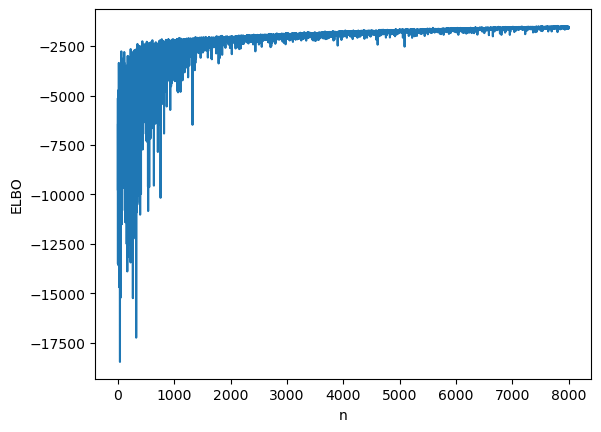

In [32]:
advi_elbo = pd.DataFrame(
    {'ELBO': -cover_0_approx.hist,
     'n': np.arange(cover_0_approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

### Cover 1 Model

In [33]:
# Cover-1 Model

with pm.Model() as Cover_1_model:
    Y = pm.MutableData(name="Y", value=Y_train["pff_passCoverage_Cover-1"])
    X = pm.MutableData(name="X", value=X_train)
    k =  X_train.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    
pm.model_to_graphviz(Cover_1_model)

with Cover_1_model:
    cover_1_approx = pm.fit(8000, method = 'advi', random_seed = 13894712)

Finished [100%]: Average Loss = 3,780.4


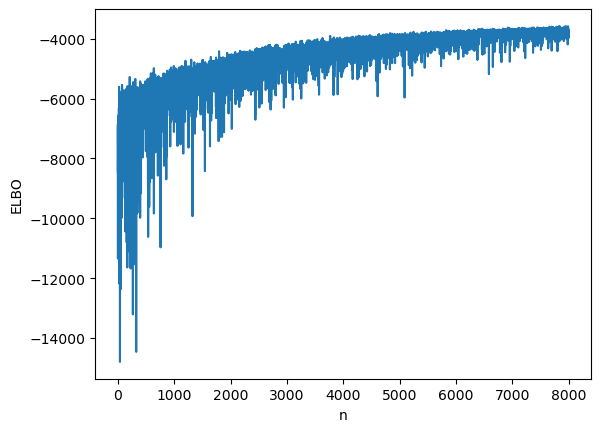

In [34]:
advi_elbo = pd.DataFrame(
    {'ELBO': -cover_1_approx.hist,
     'n': np.arange(cover_1_approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

### Cover 2 Model

Finished [100%]: Average Loss = 3,294.8


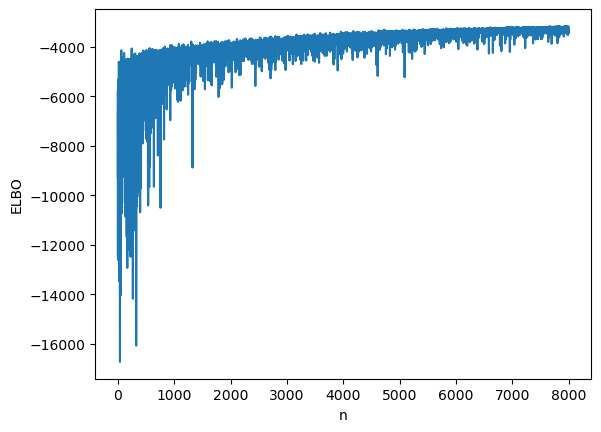

In [35]:
# Cover-2 Model

with pm.Model() as Cover_2_model:
    Y = pm.MutableData(name="Y", value=Y_train["pff_passCoverage_Cover-2"])
    X = pm.MutableData(name="X", value=X_train)
    k =  X_train.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    
pm.model_to_graphviz(Cover_2_model)

with Cover_2_model:
    cover_2_approx = pm.fit(8000, method = 'advi', random_seed = 13894712)
    
advi_elbo = pd.DataFrame(
    {'ELBO': -cover_2_approx.hist,
     'n': np.arange(cover_2_approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

### Cover 3 Model

Finished [100%]: Average Loss = 4,639.4


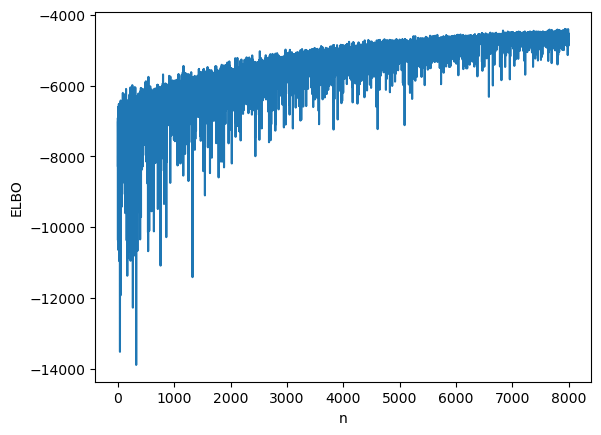

In [36]:
# Cover-3 Model

with pm.Model() as Cover_3_model:
    Y = pm.MutableData(name="Y", value=Y_train["pff_passCoverage_Cover-3"])
    X = pm.MutableData(name="X", value=X_train)
    k =  X_train.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    
pm.model_to_graphviz(Cover_3_model)

with Cover_3_model:
    cover_3_approx = pm.fit(8000, method = 'advi', random_seed = 13894712)
    
advi_elbo = pd.DataFrame(
    {'ELBO': -cover_3_approx.hist,
     'n': np.arange(cover_3_approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

### Quarters Model (Cover-4)

Finished [100%]: Average Loss = 2,974.4


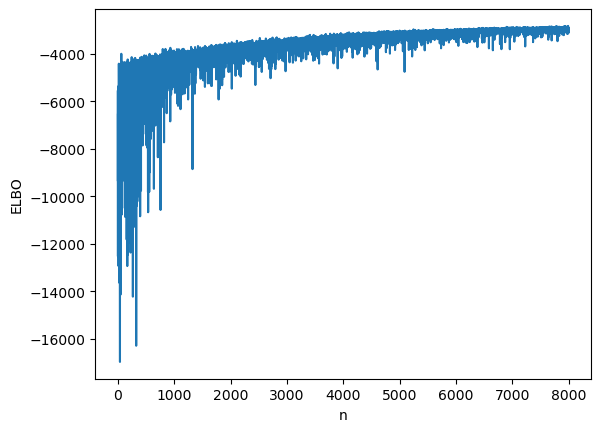

In [37]:
# Quarters Model

with pm.Model() as Quarters_model:
    Y = pm.MutableData(name="Y", value=Y_train["pff_passCoverage_Quarters"])
    X = pm.MutableData(name="X", value=X_train)
    k =  X_train.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    
pm.model_to_graphviz(Quarters_model)

with Quarters_model:
    quarters_approx = pm.fit(8000, method = 'advi', random_seed = 13894712)
    
advi_elbo = pd.DataFrame(
    {'ELBO': -quarters_approx.hist,
     'n': np.arange(quarters_approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

### 2 Man Model

Finished [100%]: Average Loss = 1,442.5


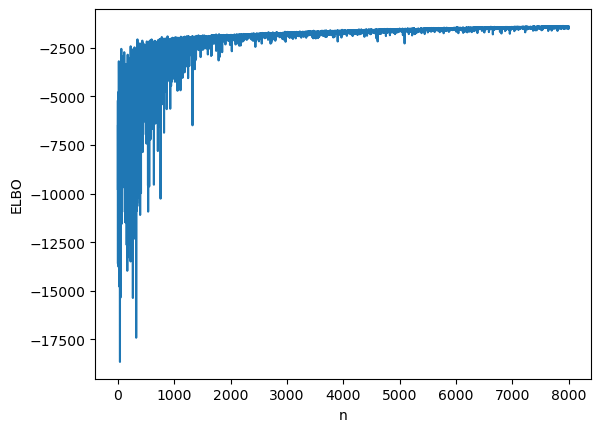

In [38]:
# 2 Man Model (Cover 5)

with pm.Model() as Two_Man_model:
    Y = pm.MutableData(name="Y", value=Y_train["pff_passCoverage_2-Man"])
    X = pm.MutableData(name="X", value=X_train)
    k =  X_train.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    
pm.model_to_graphviz(Two_Man_model)

with Two_Man_model:
    two_man_approx = pm.fit(8000, method = 'advi', random_seed = 13894712)
    
advi_elbo = pd.DataFrame(
    {'ELBO': -two_man_approx.hist,
     'n': np.arange(two_man_approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

### Cover 6 Model

Finished [100%]: Average Loss = 2,878.6


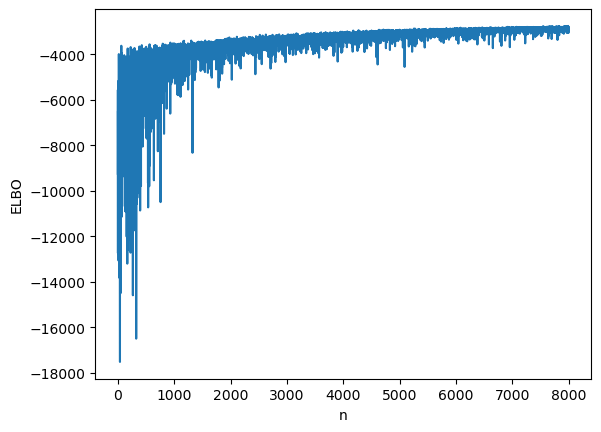

In [39]:
# Cover-6 Model

with pm.Model() as Cover_6_model:
    Y = pm.MutableData(name="Y", value=Y_train["pff_passCoverage_Cover-6"])
    X = pm.MutableData(name="X", value=X_train)
    k =  X_train.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    
pm.model_to_graphviz(Cover_6_model)

with Cover_6_model:
    cover_6_approx = pm.fit(8000, method = 'advi', random_seed = 13894712)
    
advi_elbo = pd.DataFrame(
    {'ELBO': -cover_6_approx.hist,
     'n': np.arange(cover_6_approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

# Model Performance Evaluation

In [40]:
# Cover 0 prediction
trace0 = cover_0_approx.sample(draws=5000)

pm.set_data(new_data={'X':X_test, 'Y':Y_test['pff_passCoverage_Cover-0']}, model=Cover_0_model)
# Get posterior samples of test data
ppc0 = pm.sample_posterior_predictive(trace0, model=Cover_0_model, var_names=['p', 'Yl'])

Sampling: [Yl]


In [41]:
# Cover 1 prediction
trace1 = cover_1_approx.sample(draws=5000)

pm.set_data(new_data={'X':X_test, 'Y':Y_test['pff_passCoverage_Cover-1']}, model=Cover_1_model)
# Get posterior samples of test data
ppc1 = pm.sample_posterior_predictive(trace1, model=Cover_1_model, var_names=['p', 'Yl'])

Sampling: [Yl]


In [42]:
# Cover 2 prediction
trace2 = cover_2_approx.sample(draws=5000)

pm.set_data(new_data={'X':X_test, 'Y':Y_test['pff_passCoverage_Cover-2']}, model=Cover_2_model)
# Get posterior samples of test data
ppc2 = pm.sample_posterior_predictive(trace2, model=Cover_2_model, var_names=['p', 'Yl'])

Sampling: [Yl]


In [43]:
# Cover 3 prediction
trace3 = cover_3_approx.sample(draws=5000)

pm.set_data(new_data={'X':X_test, 'Y':Y_test['pff_passCoverage_Cover-3']}, model=Cover_3_model)
# Get posterior samples of test data
ppc3 = pm.sample_posterior_predictive(trace3, model=Cover_3_model, var_names=['p', 'Yl'])

Sampling: [Yl]


In [44]:
# Quarters prediction
trace4 = quarters_approx.sample(draws=5000)

pm.set_data(new_data={'X':X_test, 'Y':Y_test['pff_passCoverage_Quarters']}, model=Quarters_model)
# Get posterior samples of test data
ppc4 = pm.sample_posterior_predictive(trace4, model=Quarters_model, var_names=['p', 'Yl'])

Sampling: [Yl]


In [45]:
# 2-Man prediction
trace5 = two_man_approx.sample(draws=5000)

pm.set_data(new_data={'X':X_test, 'Y':Y_test['pff_passCoverage_2-Man']}, model=Two_Man_model)
# Get posterior samples of test data
ppc5 = pm.sample_posterior_predictive(trace5, model=Two_Man_model, var_names=['p', 'Yl'])

Sampling: [Yl]


In [46]:
# Cover 6 prediction
trace6 = cover_6_approx.sample(draws=5000)

pm.set_data(new_data={'X':X_test, 'Y':Y_test['pff_passCoverage_Cover-6']}, model=Cover_6_model)
# Get posterior samples of test data
ppc6 = pm.sample_posterior_predictive(trace6, model=Cover_6_model, var_names=['p', 'Yl'])

Sampling: [Yl]


In [47]:
# Create a dataframe of each model output for each play to identify the predicted coverage from the model

p_hats = pd.DataFrame({
    'pff_passCoverage_Cover-0':ppc0['posterior_predictive']['p'].mean(axis=1)[0].to_numpy(),
    'pff_passCoverage_Cover-1':ppc1['posterior_predictive']['p'].mean(axis=1)[0].to_numpy(),
    'pff_passCoverage_Cover-2':ppc2['posterior_predictive']['p'].mean(axis=1)[0].to_numpy(),
    'pff_passCoverage_Cover-3':ppc3['posterior_predictive']['p'].mean(axis=1)[0].to_numpy(),
    'pff_passCoverage_Quarters':ppc4['posterior_predictive']['p'].mean(axis=1)[0].to_numpy(),
    'pff_passCoverage_2-Man':ppc5['posterior_predictive']['p'].mean(axis=1)[0].to_numpy(),
    'pff_passCoverage_Cover-6':ppc6['posterior_predictive']['p'].mean(axis=1)[0].to_numpy(),
})

In [48]:
p_hats

,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Quarters,pff_passCoverage_2-Man,pff_passCoverage_Cover-6
0,0.003431,0.056244,0.293395,0.075830,0.769614,0.002852,0.052035
1,0.016378,0.021261,0.028378,0.835924,0.434130,0.003476,0.019927
2,0.003784,0.092560,0.214699,0.343548,0.077765,0.004744,0.162807
3,0.074817,0.008429,0.211256,0.367952,0.254030,0.018056,0.052839
4,0.001858,0.117814,0.078696,0.832472,0.037496,0.001941,0.030735
...,...,...,...,...,...,...,...
1407,0.034708,0.056666,0.022719,0.544557,0.208202,0.001425,0.097144
1408,0.022651,0.195415,0.111299,0.410723,0.050885,0.006991,0.050394
1409,0.019088,0.016452,0.214282,0.290560,0.309909,0.052371,0.175996
1410,0.007886,0.101974,0.154294,0.356831,0.130041,0.090196,0.030997


In [49]:
# Determine the coverage with the highest posterior probability in the model and select that coverage as the predicted coverage.

p_hats['predicted'] = p_hats.idxmax(axis=1)

In [50]:
# Encode the actual coverages for comparison with the predicted

Y_test_coverages = Y_test.idxmax(axis=1)
p_hats['actual'] = Y_test_coverages.reset_index(drop=True)
p_hats

,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Quarters,pff_passCoverage_2-Man,pff_passCoverage_Cover-6,predicted,actual
0,0.003431,0.056244,0.293395,0.075830,0.769614,0.002852,0.052035,pff_passCoverage_Quarters,pff_passCoverage_Quarters
1,0.016378,0.021261,0.028378,0.835924,0.434130,0.003476,0.019927,pff_passCoverage_Cover-3,pff_passCoverage_Cover-3
2,0.003784,0.092560,0.214699,0.343548,0.077765,0.004744,0.162807,pff_passCoverage_Cover-3,pff_passCoverage_Cover-3
3,0.074817,0.008429,0.211256,0.367952,0.254030,0.018056,0.052839,pff_passCoverage_Cover-3,pff_passCoverage_Quarters
4,0.001858,0.117814,0.078696,0.832472,0.037496,0.001941,0.030735,pff_passCoverage_Cover-3,pff_passCoverage_Cover-1
...,...,...,...,...,...,...,...,...,...
1407,0.034708,0.056666,0.022719,0.544557,0.208202,0.001425,0.097144,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6
1408,0.022651,0.195415,0.111299,0.410723,0.050885,0.006991,0.050394,pff_passCoverage_Cover-3,pff_passCoverage_Cover-3
1409,0.019088,0.016452,0.214282,0.290560,0.309909,0.052371,0.175996,pff_passCoverage_Quarters,pff_passCoverage_Cover-6
1410,0.007886,0.101974,0.154294,0.356831,0.130041,0.090196,0.030997,pff_passCoverage_Cover-3,pff_passCoverage_Quarters


In [51]:
# Accuracy
(p_hats['predicted']==p_hats['actual']).sum()/len(p_hats)

0.4794617563739377

#### Accuracy is printed above!

# Creating Histogram of the Results

## Histograms of Mean Probability for Each Coverage

In [52]:
summary0 = az.summary(ppc0, round_to=2)

/Users/joshgen/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1366: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


In [53]:
summary0[:1412]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.00,0.02,0.0,0.01,0.0,0.0,5117.59,4662.40,NaN
p[1],0.02,0.06,0.0,0.06,0.0,0.0,5024.40,4903.00,NaN
p[2],0.00,0.01,0.0,0.01,0.0,0.0,5380.78,5108.11,NaN
p[3],0.07,0.13,0.0,0.32,0.0,0.0,4746.91,4602.00,NaN
p[4],0.00,0.01,0.0,0.01,0.0,0.0,5215.13,4959.87,NaN
...,...,...,...,...,...,...,...,...,...
p[1407],0.03,0.07,0.0,0.14,0.0,0.0,5041.97,4723.41,NaN
p[1408],0.02,0.06,0.0,0.09,0.0,0.0,4974.56,4932.57,NaN
p[1409],0.02,0.06,0.0,0.07,0.0,0.0,5123.85,4263.92,NaN
p[1410],0.01,0.03,0.0,0.03,0.0,0.0,4785.90,4603.09,NaN


In [54]:
summary0 = az.summary(ppc0, round_to=3)
summary0 = summary0[:1412]
summary1 = az.summary(ppc1, round_to=3)
summary1 = summary1[:1412]
summary2 = az.summary(ppc2, round_to=3)
summary2 = summary2[:1412]
summary3 = az.summary(ppc3, round_to=3)
summary3 = summary3[:1412]
summary4 = az.summary(ppc4, round_to=3)
summary4 = summary4[:1412]
summary5 = az.summary(ppc5, round_to=3)
summary5 = summary5[:1412]
summary6 = az.summary(ppc6, round_to=3)
summary6 = summary6[:1412]

/Users/joshgen/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1366: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
/Users/joshgen/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1366: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
/Users/joshgen/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1366: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
/Users/joshge

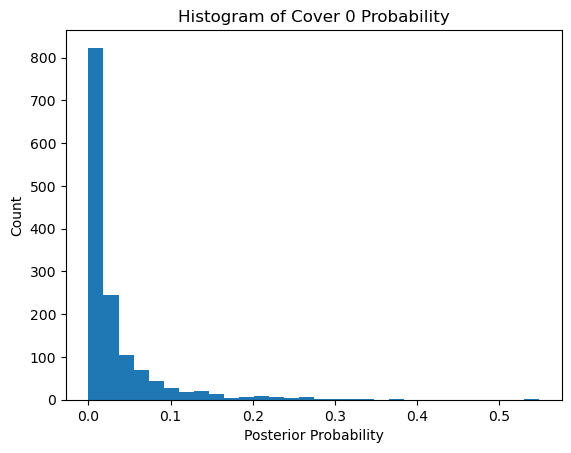

In [55]:
plt.hist(summary0[['mean']], bins=30)
plt.title('Histogram of Cover 0 Probability')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

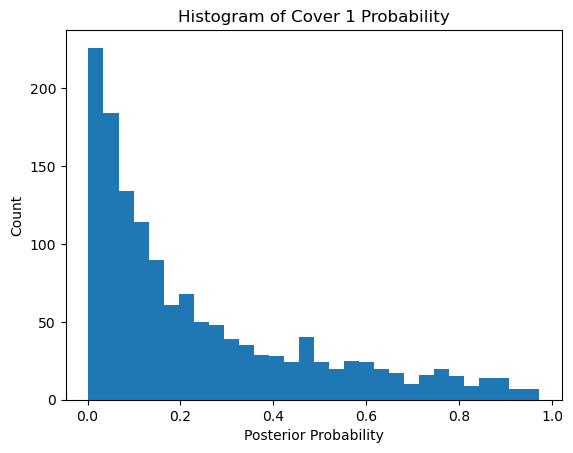

In [291]:
plt.hist(summary1[['mean']], bins=30)
plt.title('Histogram of Cover 1 Probability')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

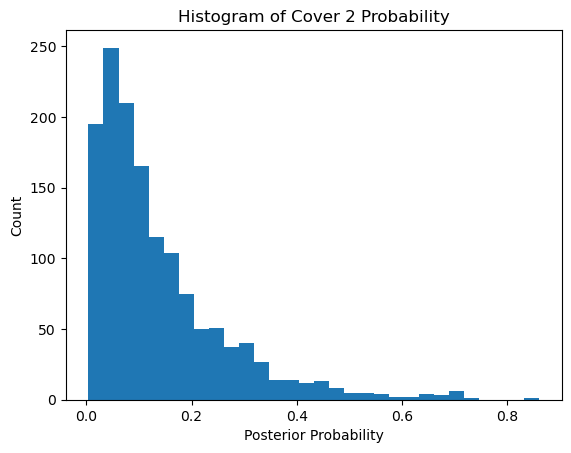

In [292]:
plt.hist(summary2[['mean']], bins=30)
plt.title('Histogram of Cover 2 Probability')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

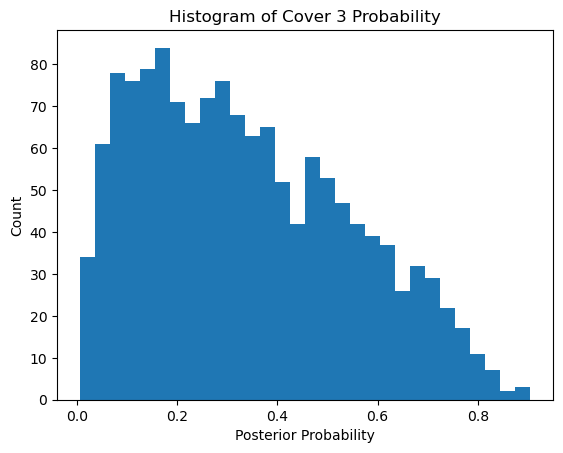

In [293]:
plt.hist(summary3[['mean']], bins=30)
plt.title('Histogram of Cover 3 Probability')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

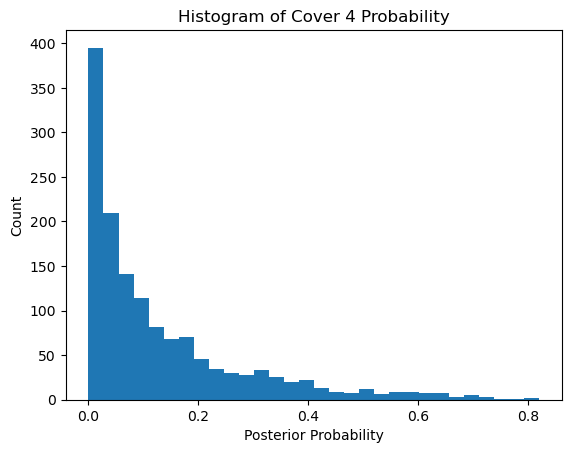

In [294]:
plt.hist(summary4[['mean']], bins=30)
plt.title('Histogram of Cover 4 Probability')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

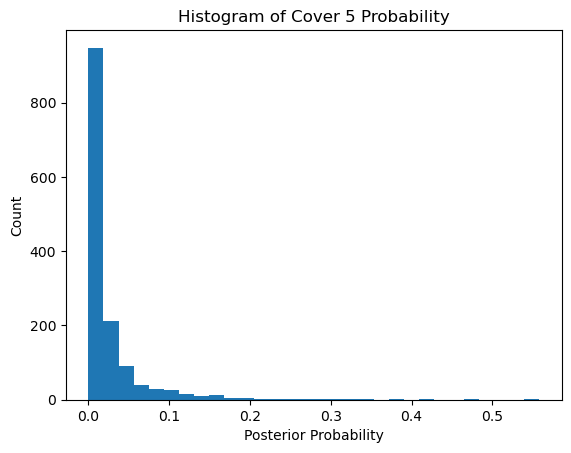

In [295]:
plt.hist(summary5[['mean']], bins=30)
plt.title('Histogram of Cover 5 Probability')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

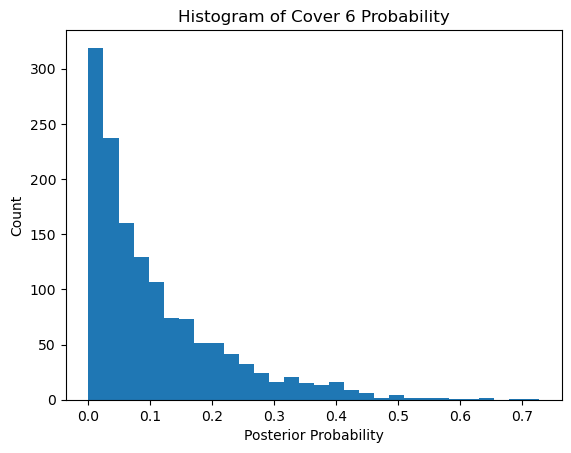

In [296]:
plt.hist(summary6[['mean']], bins=30)
plt.title('Histogram of Cover 6 Probability')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

## Histograms of Lower Bound and Upper Bound of the Probability for Each Coverage

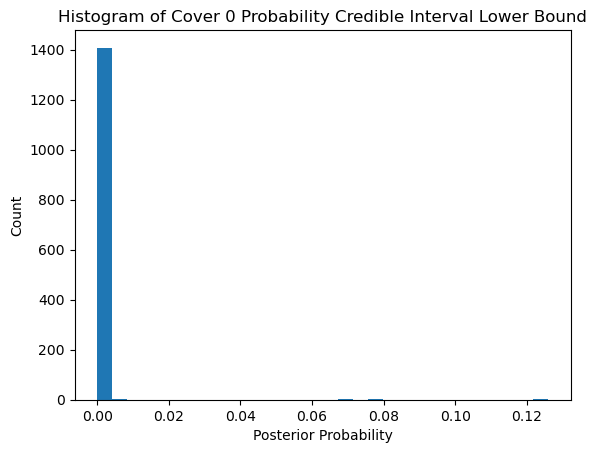

In [297]:
plt.hist(summary0[['hdi_3%']], bins=30)
plt.title('Histogram of Cover 0 Probability Credible Interval Lower Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

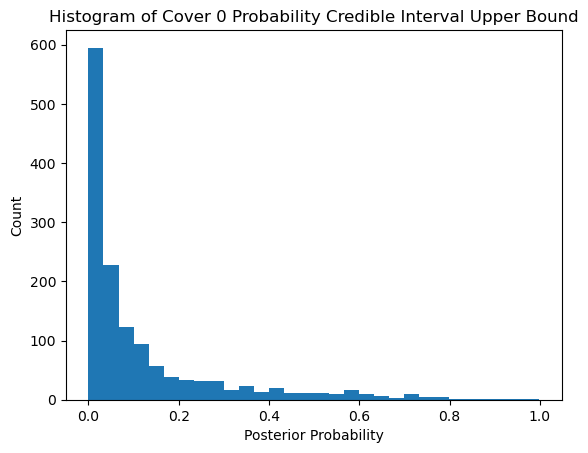

In [298]:
plt.hist(summary0[['hdi_97%']], bins=30)
plt.title('Histogram of Cover 0 Probability Credible Interval Upper Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

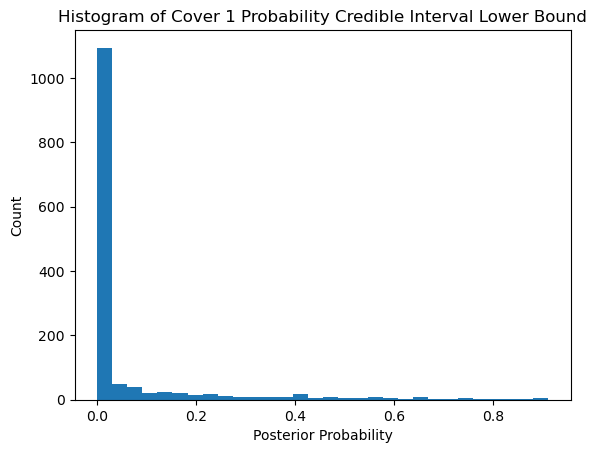

In [299]:
plt.hist(summary1[['hdi_3%']], bins=30)
plt.title('Histogram of Cover 1 Probability Credible Interval Lower Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

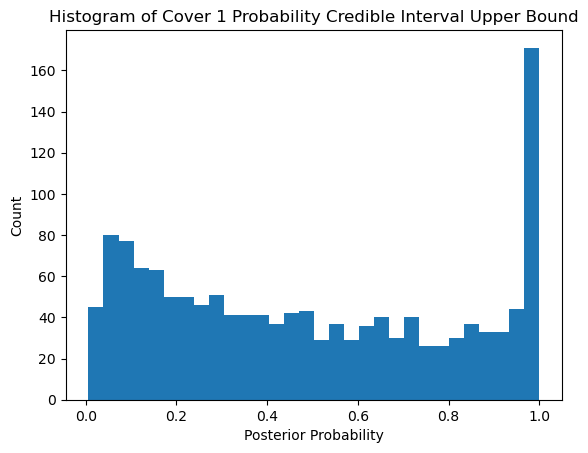

In [300]:
plt.hist(summary1[['hdi_97%']], bins=30)
plt.title('Histogram of Cover 1 Probability Credible Interval Upper Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

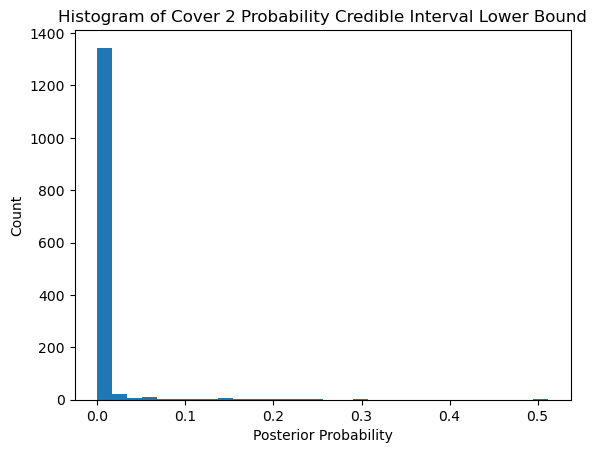

In [301]:
plt.hist(summary2[['hdi_3%']], bins=30)
plt.title('Histogram of Cover 2 Probability Credible Interval Lower Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

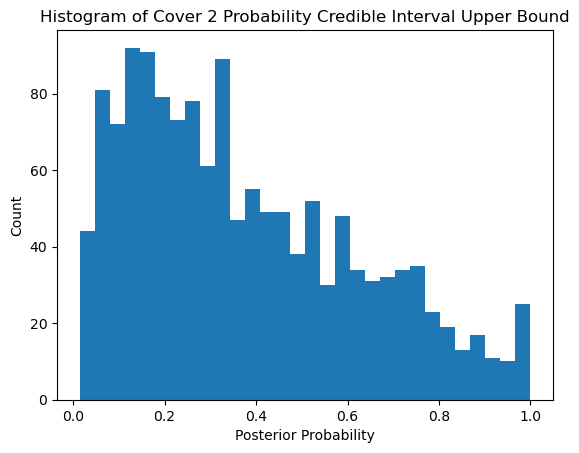

In [302]:
plt.hist(summary2[['hdi_97%']], bins=30)
plt.title('Histogram of Cover 2 Probability Credible Interval Upper Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

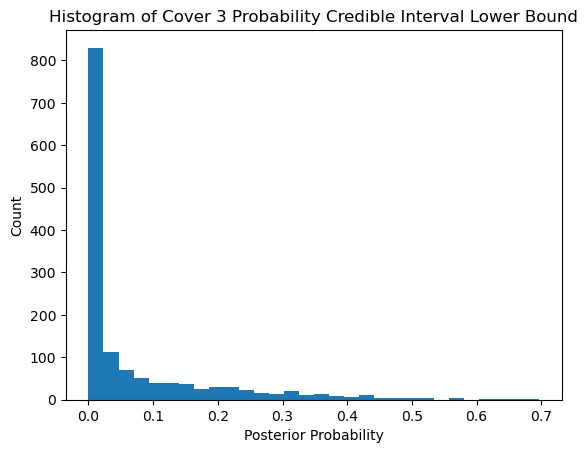

In [303]:
plt.hist(summary3[['hdi_3%']], bins=30)
plt.title('Histogram of Cover 3 Probability Credible Interval Lower Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

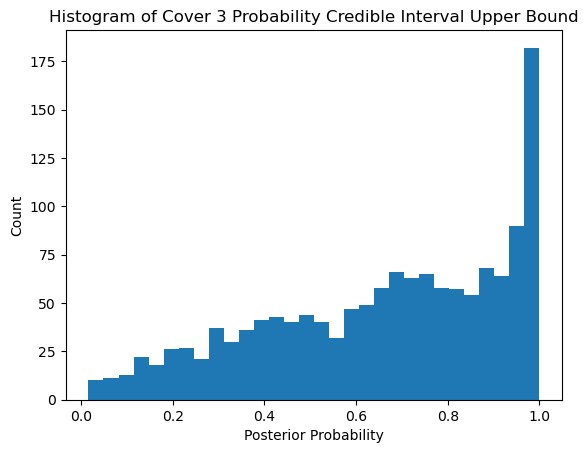

In [304]:
plt.hist(summary3[['hdi_97%']], bins=30)
plt.title('Histogram of Cover 3 Probability Credible Interval Upper Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

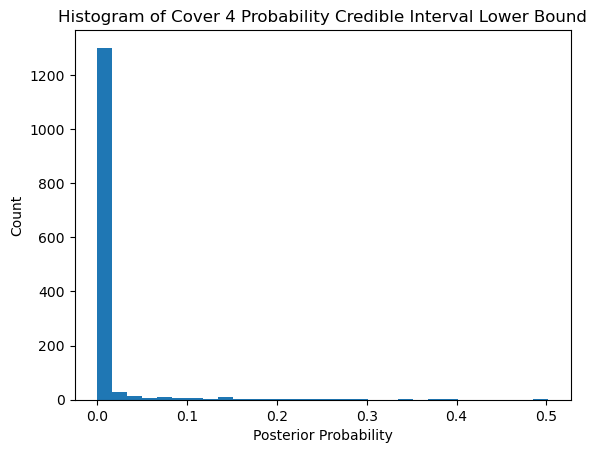

In [305]:
plt.hist(summary4[['hdi_3%']], bins=30)
plt.title('Histogram of Cover 4 Probability Credible Interval Lower Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

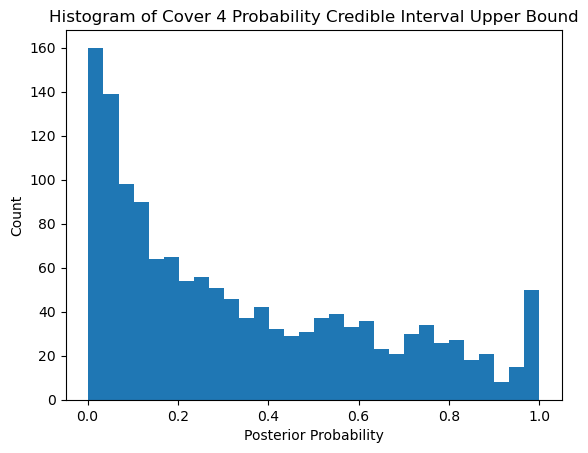

In [306]:
plt.hist(summary4[['hdi_97%']], bins=30)
plt.title('Histogram of Cover 4 Probability Credible Interval Upper Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

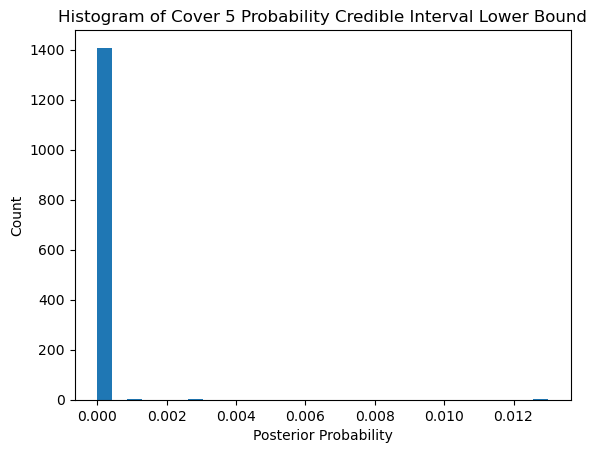

In [307]:
plt.hist(summary5[['hdi_3%']], bins=30)
plt.title('Histogram of Cover 5 Probability Credible Interval Lower Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

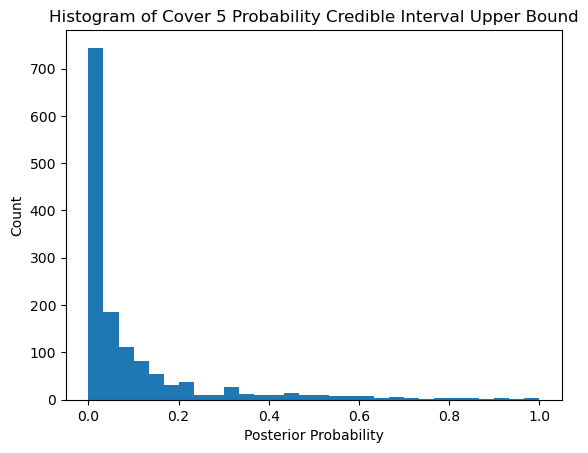

In [308]:
plt.hist(summary5[['hdi_97%']], bins=30)
plt.title('Histogram of Cover 5 Probability Credible Interval Upper Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

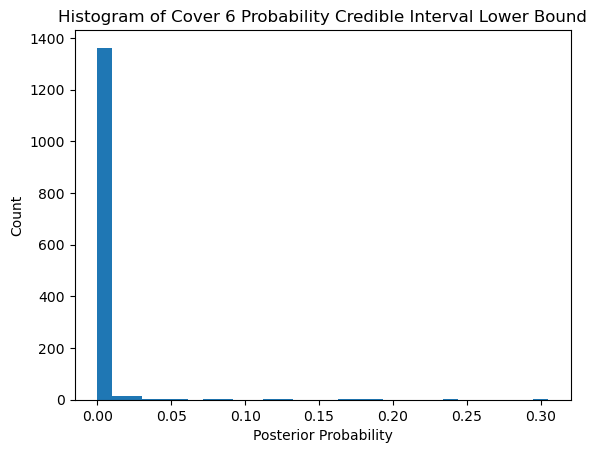

In [309]:
plt.hist(summary6[['hdi_3%']], bins=30)
plt.title('Histogram of Cover 6 Probability Credible Interval Lower Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

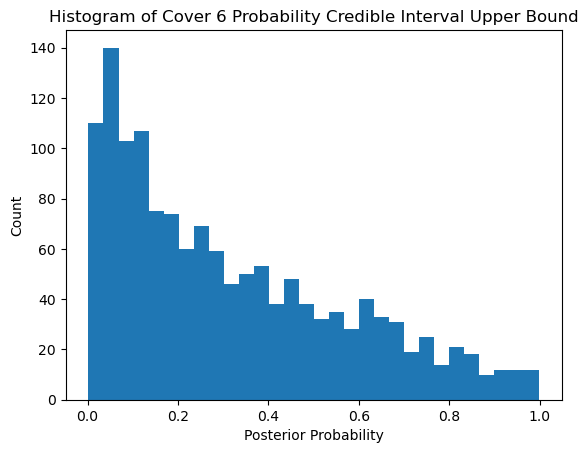

In [310]:
plt.hist(summary6[['hdi_97%']], bins=30)
plt.title('Histogram of Cover 6 Probability Credible Interval Upper Bound')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

## Histograms of Standard Deviation of Probability for Each Coverage

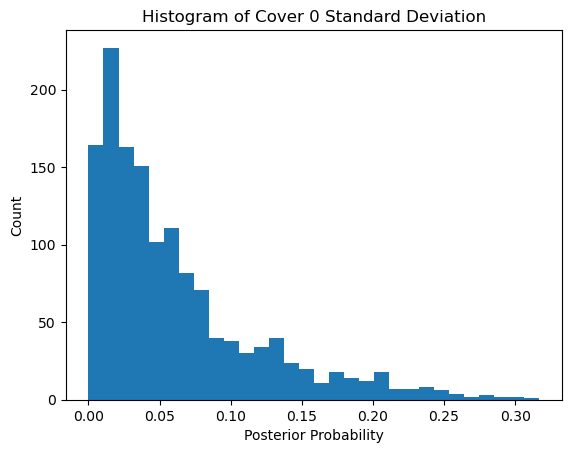

In [349]:
plt.hist(summary0[['sd']], bins=30)
plt.title('Histogram of Cover 0 Standard Deviation')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

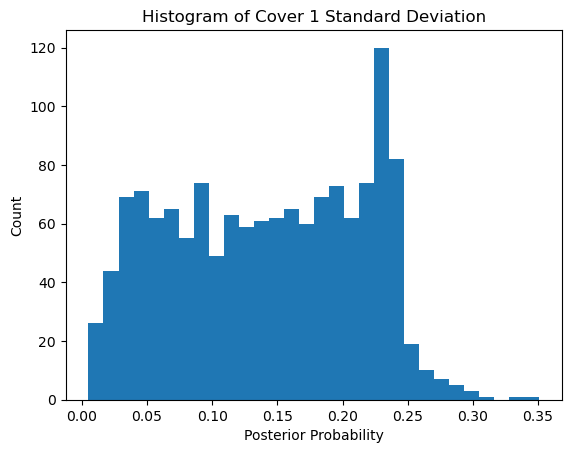

In [350]:
plt.hist(summary1[['sd']], bins=30)
plt.title('Histogram of Cover 1 Standard Deviation')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

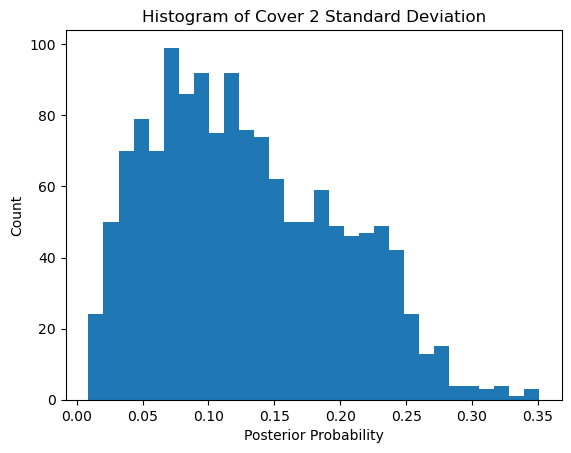

In [351]:
plt.hist(summary2[['sd']], bins=30)
plt.title('Histogram of Cover 2 Standard Deviation')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

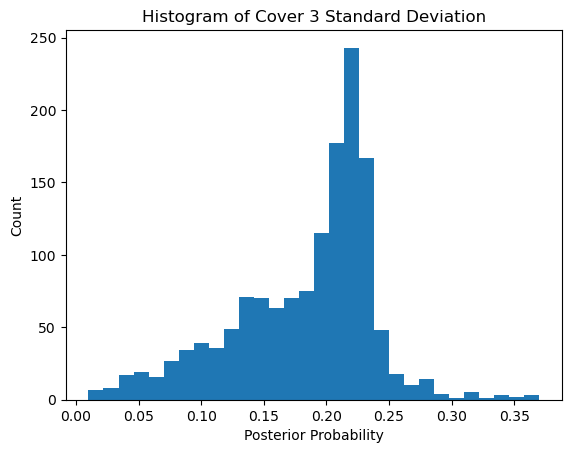

In [352]:
plt.hist(summary3[['sd']], bins=30)
plt.title('Histogram of Cover 3 Standard Deviation')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

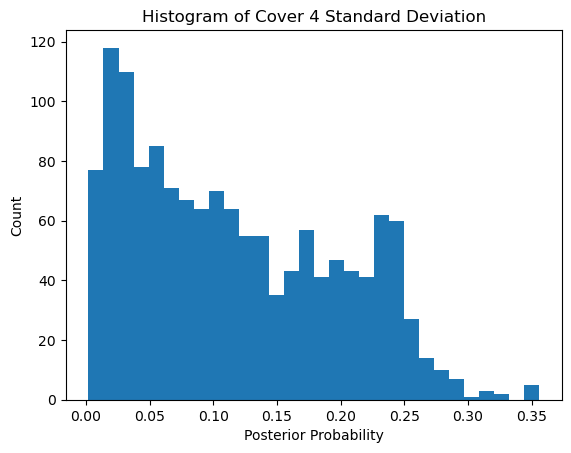

In [353]:
plt.hist(summary4[['sd']], bins=30)
plt.title('Histogram of Cover 4 Standard Deviation')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

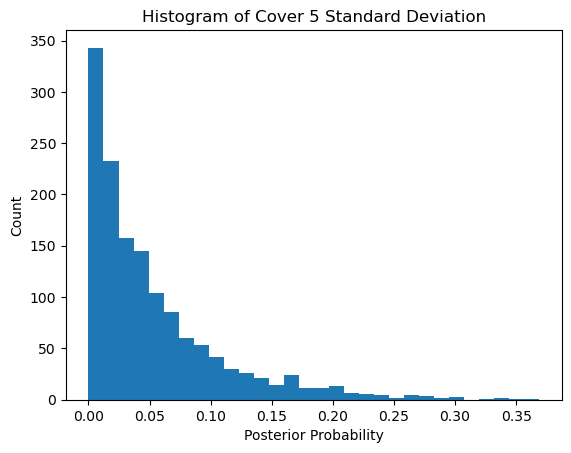

In [354]:
plt.hist(summary5[['sd']], bins=30)
plt.title('Histogram of Cover 5 Standard Deviation')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

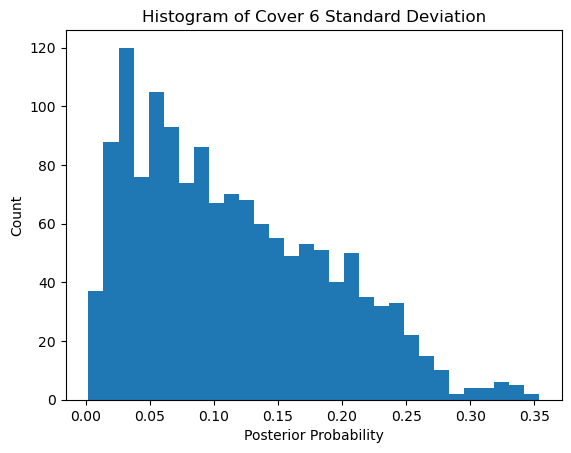

In [355]:
plt.hist(summary6[['sd']], bins=30)
plt.title('Histogram of Cover 6 Standard Deviation')
plt.xlabel('Posterior Probability')
plt.ylabel('Count');

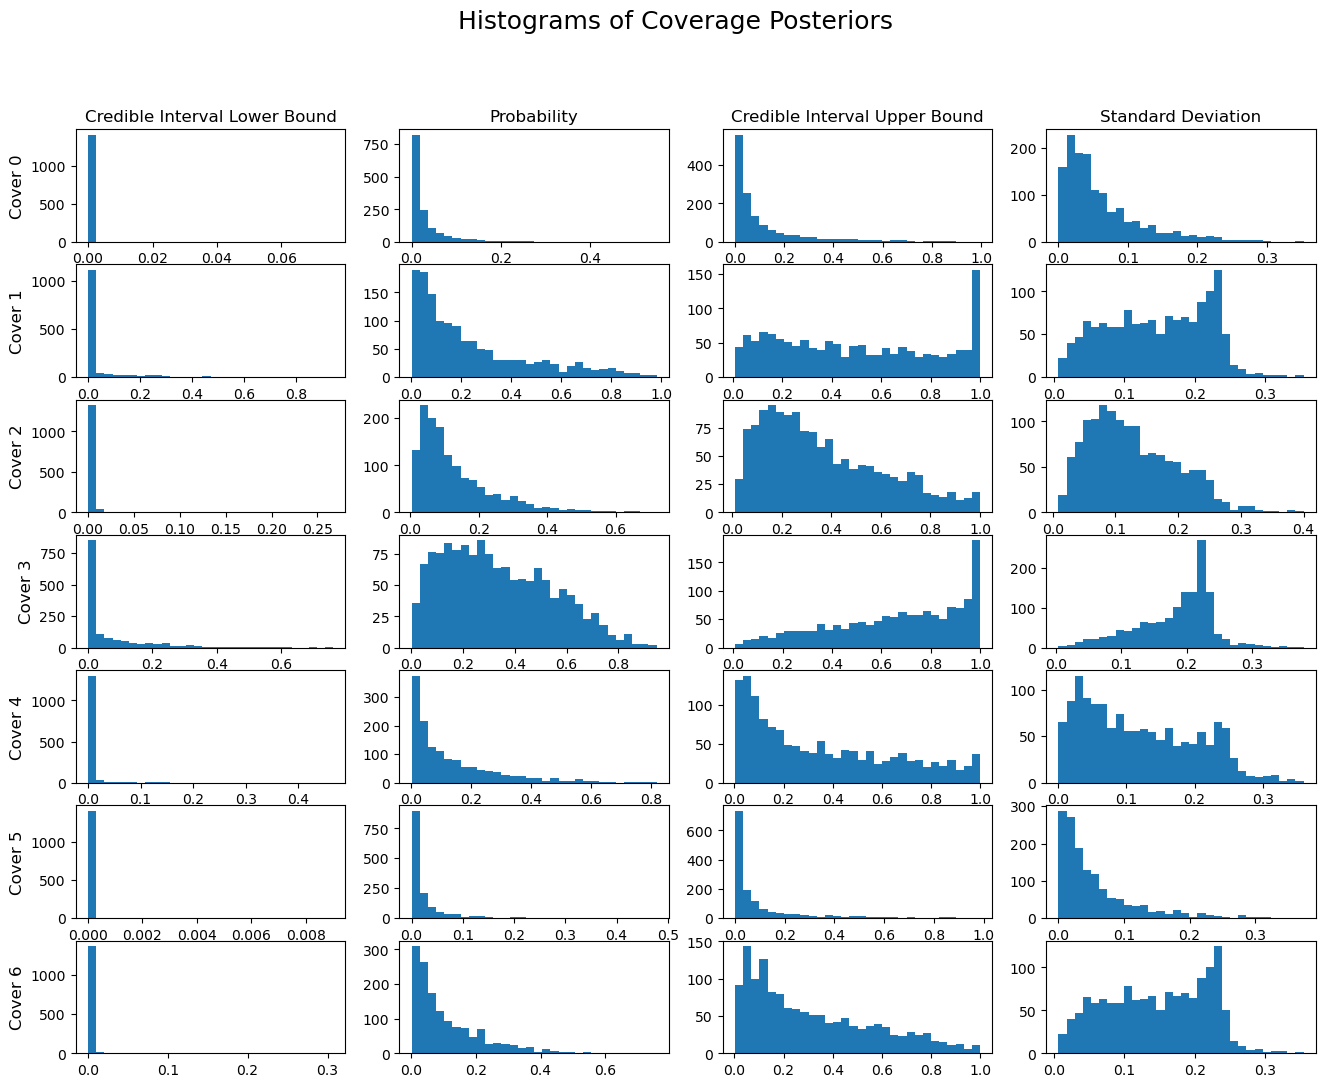

In [71]:
fig, axs = plt.subplots(7, 4, figsize=(16, 12))

axs[0, 0].hist(summary0[['hdi_3%']], bins=30)

axs[1, 0].hist(summary1[['hdi_3%']], bins=30)

axs[2, 0].hist(summary2[['hdi_3%']], bins=30)

axs[3, 0].hist(summary3[['hdi_3%']], bins=30)

axs[4, 0].hist(summary4[['hdi_3%']], bins=30)

axs[5, 0].hist(summary5[['hdi_3%']], bins=30)

axs[6, 0].hist(summary6[['hdi_3%']], bins=30)

axs[0, 1].hist(summary0[['mean']], bins=30)

axs[1, 1].hist(summary1[['mean']], bins=30)

axs[2, 1].hist(summary2[['mean']], bins=30)

axs[3, 1].hist(summary3[['mean']], bins=30)

axs[4, 1].hist(summary4[['mean']], bins=30)

axs[5, 1].hist(summary5[['mean']], bins=30)

axs[6, 1].hist(summary6[['mean']], bins=30)

axs[0, 2].hist(summary0[['hdi_97%']], bins=30)

axs[1, 2].hist(summary1[['hdi_97%']], bins=30)

axs[2, 2].hist(summary2[['hdi_97%']], bins=30)

axs[3, 2].hist(summary3[['hdi_97%']], bins=30)

axs[4, 2].hist(summary4[['hdi_97%']], bins=30)

axs[5, 2].hist(summary5[['hdi_97%']], bins=30)

axs[6, 2].hist(summary6[['hdi_97%']], bins=30)

axs[0, 3].hist(summary0[['sd']], bins=30)

axs[1, 3].hist(summary1[['sd']], bins=30)

axs[2, 3].hist(summary2[['sd']], bins=30)

axs[3, 3].hist(summary3[['sd']], bins=30)

axs[4, 3].hist(summary4[['sd']], bins=30)

axs[5, 3].hist(summary5[['sd']], bins=30)

axs[6, 3].hist(summary1[['sd']], bins=30)

rows = ['Cover {}'.format(col) for col in range(0, 7)]
cols = ['Credible Interval Lower Bound', 'Probability', 'Credible Interval Upper Bound', 'Standard Deviation']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

fig.suptitle("Histograms of Coverage Posteriors", fontsize=18);

# Creating a Heatmap of Correct vs. Predicted (Confusion Matrix)

In [319]:
p_hats[['actual', 'predicted']]

,actual,predicted
0,pff_passCoverage_Quarters,pff_passCoverage_Cover-3
1,pff_passCoverage_Cover-6,pff_passCoverage_Cover-2
2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-3
3,pff_passCoverage_Cover-6,pff_passCoverage_Quarters
4,pff_passCoverage_Cover-2,pff_passCoverage_Cover-1
...,...,...
1407,pff_passCoverage_Cover-3,pff_passCoverage_Cover-2
1408,pff_passCoverage_Cover-3,pff_passCoverage_Cover-3
1409,pff_passCoverage_Cover-3,pff_passCoverage_Cover-3
1410,pff_passCoverage_Cover-1,pff_passCoverage_Cover-1


In [359]:
map_dict = {'pff_passCoverage_2-Man':'Cover_5', 'pff_passCoverage_Cover-0':'Cover_0',
       'pff_passCoverage_Cover-1':'Cover_1', 'pff_passCoverage_Cover-2':"Cover_2",
       'pff_passCoverage_Cover-3':'Cover_3', 'pff_passCoverage_Cover-6':'Cover_6',
       'pff_passCoverage_Quarters':'Cover_4'}
p_hats['actual'] = p_hats['actual'].map(map_dict)
p_hats['predicted'] = p_hats['predicted'].map(map_dict)

In [360]:
prediction_freq = p_hats[['actual', 'predicted']].groupby(['actual', 'predicted']).size().unstack(fill_value=0)
prediction_freq

predicted,Cover_0,Cover_1,Cover_2,Cover_3,Cover_4,Cover_5,Cover_6
actual,,,,,,,
Cover_0,1,17,2,18,5,0,2
Cover_1,0,219,14,86,7,2,8
Cover_2,0,40,47,82,25,0,15
Cover_3,0,80,14,326,32,0,17
Cover_4,4,14,19,79,51,0,21
Cover_5,0,24,2,7,2,2,1
Cover_6,0,18,18,52,21,0,18


In [362]:
prediction_percent = prediction_freq.div(prediction_freq.sum(axis=1), axis=0)

In [363]:
prediction_percent

predicted,Cover_0,Cover_1,Cover_2,Cover_3,Cover_4,Cover_5,Cover_6
actual,,,,,,,
Cover_0,0.022222,0.377778,0.044444,0.400000,0.111111,0.000000,0.044444
Cover_1,0.000000,0.651786,0.041667,0.255952,0.020833,0.005952,0.023810
Cover_2,0.000000,0.191388,0.224880,0.392344,0.119617,0.000000,0.071770
Cover_3,0.000000,0.170576,0.029851,0.695096,0.068230,0.000000,0.036247
Cover_4,0.021277,0.074468,0.101064,0.420213,0.271277,0.000000,0.111702
Cover_5,0.000000,0.631579,0.052632,0.184211,0.052632,0.052632,0.026316
Cover_6,0.000000,0.141732,0.141732,0.409449,0.165354,0.000000,0.141732


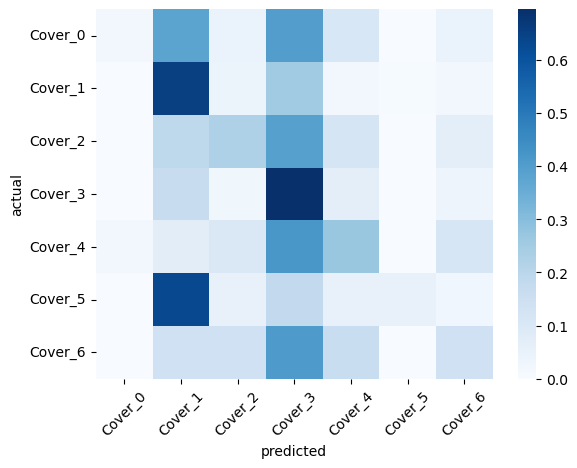

In [364]:
sns.heatmap(prediction_percent, cmap='Blues');
plt.xticks(rotation=45);